# Hybrid Model (CNN + LSTM)

In [160]:
from keras.backend import clear_session
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, TimeDistributed, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.layers import GlobalMaxPooling1D

In [161]:
# Load data
lotto_data = pd.read_csv("lotto_data_1_to_1148.csv")

In [162]:
print(lotto_data.head())
print(lotto_data.tail())
print(lotto_data.info())

   Round        Date                   Numbers  Bonus
0      1  2002-12-07  [10, 23, 29, 33, 37, 40]     16
1      2  2002-12-14   [9, 13, 21, 25, 32, 42]      2
2      3  2002-12-21  [11, 16, 19, 21, 27, 31]     30
3      4  2002-12-28  [14, 27, 30, 31, 40, 42]      2
4      5  2003-01-04  [16, 24, 29, 40, 41, 42]      3
      Round        Date                  Numbers  Bonus
1143   1144  2024-11-02   [3, 4, 12, 15, 26, 34]      6
1144   1145  2024-11-09  [2, 11, 31, 33, 37, 44]     32
1145   1146  2024-11-16  [6, 11, 17, 19, 40, 43]     28
1146   1147  2024-11-23  [7, 11, 24, 26, 27, 37]     32
1147   1148  2024-11-30   [3, 6, 13, 15, 16, 22]     32
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Round    1148 non-null   int64 
 1   Date     1148 non-null   object
 2   Numbers  1148 non-null   object
 3   Bonus    1148 non-null   int64 
dtypes: int6

In [163]:
features = lotto_data.iloc[:, 1:].values

In [164]:
lotto_numbers = lotto_data.iloc[:, 1:] 

In [165]:
print(lotto_numbers.tail())

            Date                  Numbers  Bonus
1143  2024-11-02   [3, 4, 12, 15, 26, 34]      6
1144  2024-11-09  [2, 11, 31, 33, 37, 44]     32
1145  2024-11-16  [6, 11, 17, 19, 40, 43]     28
1146  2024-11-23  [7, 11, 24, 26, 27, 37]     32
1147  2024-11-30   [3, 6, 13, 15, 16, 22]     32


In [166]:
lotto_data['Number_1'] = lotto_data['Numbers'].apply(lambda x: int(x.strip('[]').split(', ')[0]))
lotto_data['Number_2'] = lotto_data['Numbers'].apply(lambda x: int(x.strip('[]').split(', ')[1]))
lotto_data['Number_3'] = lotto_data['Numbers'].apply(lambda x: int(x.strip('[]').split(', ')[2]))
lotto_data['Number_4'] = lotto_data['Numbers'].apply(lambda x: int(x.strip('[]').split(', ')[3]))
lotto_data['Number_5'] = lotto_data['Numbers'].apply(lambda x: int(x.strip('[]').split(', ')[4]))
lotto_data['Number_6'] = lotto_data['Numbers'].apply(lambda x: int(x.strip('[]').split(', ')[5]))

In [167]:
lotto_data_cleaned = lotto_data.drop(['Date', 'Numbers'], axis=1)

In [168]:
print(lotto_data_cleaned.tail())

      Round  Bonus  Number_1  Number_2  Number_3  Number_4  Number_5  Number_6
1143   1144      6         3         4        12        15        26        34
1144   1145     32         2        11        31        33        37        44
1145   1146     28         6        11        17        19        40        43
1146   1147     32         7        11        24        26        27        37
1147   1148     32         3         6        13        15        16        22


In [169]:
scaler = MinMaxScaler()
features = lotto_data_cleaned.drop(['Round'], axis=1).values
features_normalized = scaler.fit_transform(features)

## Prepare Time-Series Data

In [170]:
# Create time-series data
def create_sequences(data, sequence_length=10):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length, 1:])  # Feature data (Numbers + Bonus)
        y.append(data[i + sequence_length, 1:])   # Target data (next numbers)
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(features_normalized, sequence_length)

print("Input data shape:", X.shape)
print("Output data shape:", y.shape)

Input data shape: (1138, 10, 6)
Output data shape: (1138, 6)


## Train-Test Split

In [171]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## CNN + LSTM Model

In [172]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout

In [173]:
# Build the model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(6, activation='linear')  # Predict Numbers 1-6
])

c:\Users\godsj\miniconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [174]:
# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 8, 64)          │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,072 (105.75 KB)

 Trainable params: 27,072 (105.75 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [175]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.2260 - val_loss: 0.0470
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0477 - val_loss: 0.0418
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0405 - val_loss: 0.0414
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0400 - val_loss: 0.0414
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0413 - val_loss: 0.0411
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0392 - val_loss: 0.0421
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0394 - val_loss: 0.0412
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0392 - val_loss: 0.0419
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0404 - val_loss: 0.0401
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0396 - val_loss: 0.0405
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0376 - val_loss: 0.0404
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0389 - val_l

In [176]:
# Remove Bonus column for training and prediction
features = lotto_data_cleaned.drop(['Round', 'Bonus'], axis=1).values

# Normalize features
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)

## Make Predictions

In [177]:
# Predict next sequence
last_sequence = features_normalized[-sequence_length:]  # Last 10 sequences
last_sequence = np.expand_dims(last_sequence, axis=0)  # Add batch dimension
predicted_numbers = model.predict(last_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


In [180]:
# Inverse transform to get original scale
predicted_numbers_original = scaler.inverse_transform(predicted_numbers)
print("Predicted next lotto numbers:", predicted_numbers_original[0].round().astype(int))

Predicted next lotto numbers: [ 7 12 19 25 31 39]


## Plot Training and Validation Loss

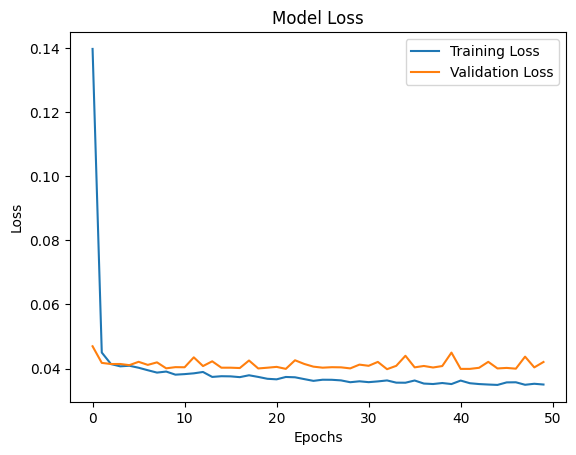

In [181]:
import matplotlib.pyplot as plt

# Plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [183]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss}")

Test Loss: 0.042064521461725235


In [186]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and MSE
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
mse = mean_squared_error(y_test.flatten(), y_pred.flatten())

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 0.1661619844942415
Mean Squared Error (MSE): 0.04206451666885987
